# Preliminary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, List
from tqdm import tqdm
from collections import defaultdict
import constants
from sklearn.cluster import KMeans
from tqdm import tqdm
from collections import defaultdict
from cop_kmeans import cop_kmeans
import itertools

plt.rcParams['text.usetex'] = True

### Get tangent vectors

In [2]:
def tangent(ra: float, dec: float) -> Tuple[np.ndarray, np.ndarray]:
    """Returns the tangent vectors pointing to west and north.

    Args:
        ra (float): right ascension in degrees
        dec (float): declination in degrees

    Returns:
        tuple[float,float]: west and north vectors
    """
    # Convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    
    # Get sin and cos of ra and dec
    sinRa = np.sin(ra)
    cosRa = np.cos(ra)
    sinDec = np.sin(dec)
    cosDec = np.cos(dec)
    
    # Get tangent vectors
    west = np.array([sinRa, -cosRa, 0])
    north = np.array([-sinDec * cosRa, -sinDec * sinRa, cosDec])
    return west, north

### Negative Log Bayes Factor

This was previously numerically inaccurate because the $\kappa_{(i,c)}$ in radians for the real data is on the order of $10^{13}$. However, we always take the $\log$ of those terms. So, we can utilize the following more numerically accurate calculation:

Let $\kappa_{(i,c)}$ be in $\text{arcseconds}^{-2}$. Then, to convert to $\text{rad}^{-2}$, we multiply by $C=(\pi/180/3600)^{-2}$. $C$ is the large number which makes the numerical calculations inaccurate. Then, we can use the following identities to keep all intermediate numbers small:
$$
\sum_{(i,c)\in O} \log(C\kappa_{(i,c)}) = \sum_{(i,c)\in O} (\log(C) + \log(\kappa_{(i,c)})) = |S_o|\log(C) +  \sum_{(i,c)\in O}\log(\kappa_{(i,c)}))
$$
$$
\log\left(\sum_{(i,c)\in O} C\kappa_{(i,c)}\right) = \log\left(C\sum_{(i,c)\in O} \kappa_{(i,c)}\right) = \log(C) + \log\left(\sum_{(i,c)\in O} \kappa_{(i,c)}\right)
$$

In [3]:
def neg_log_bayes(data_df: pd.DataFrame, labels: List[int]) -> float:
    """ Calculate negative log bayes factor using the given labels.

    Args:
        data_df (pd.DataFrame): Data dataframe with coordinates and uncertainties
        labels (list[int]): integer array of labels

    Returns:
        float: negative log bayes factor
    """
    out = 0
    # preprocess labels to make sure 0 through max number of labels
    labels = pd.factorize(labels)[0]
    
    # Set column of dataframe for indexing by label
    data_df["labels"] = labels
    
    for i in range(max(labels) + 1):
        # filter data to sources labeled to i
        data_labeled = data_df[data_df.labels == i]
        
        num_sources = data_labeled.shape[0]

        # get 2D coordinates of sources
        # coords = data_labeled[["coord1 (arcseconds)", "coord2 (arcseconds)"]]
        coord1 = data_labeled["coord1 (arcseconds)"]
        coord2 = data_labeled["coord2 (arcseconds)"]
        weights = data_labeled["kappa"]
        
        weights_sum = weights.sum()

        # Get centroid
        centroid1 = (coord1 * weights).sum() / weights_sum
        centroid2 = (coord2 * weights).sum() / weights_sum

        # Get number of sources
        num_sources = data_labeled.shape[0]

        # Get kappa sums
        # sum_ln_kappa_rad = data_labeled["log kappa (radians)"].sum()
        # ln_sum_kappa_rad = np.log(data_labeled["kappa (radians)"].sum())
        
        C = np.log(constants.ARCSEC_TO_RAD_2)
        ln_sum_kappa_rad = C + np.log(weights_sum)
        sum_ln_kappa_rad = (C * num_sources) + np.log(weights).sum()

        # Get sum of pairwise distances between all sources
        square_dist_weighted = weights * (np.power(coord1 - centroid1, 2) + np.power(coord2 - centroid2, 2))
        sum_of_square_dist = square_dist_weighted.sum()
        
        # Divide by 2
        double_sum = sum_of_square_dist / 2
        
        # Add up all terms
        out += (1 - num_sources) * np.log(2) - sum_ln_kappa_rad + double_sum + ln_sum_kappa_rad
        
    # Remove the label column
    del data_df["labels"]

    return out

### KMeans and COP-KMeans

In [4]:
def run_kmeans(data_df: pd.DataFrame, min_k: int, max_k: int) -> Tuple[List[int],int,float]:
    coords = data_df[["coord1 (arcseconds)", "coord2 (arcseconds)"]]
    weights = data_df["kappa"]

    best_labels = None
    best_k = 0
    best_bayes = np.Inf

    for k in tqdm(range(min_k,max_k)):
        kmeans = KMeans(n_clusters=k, random_state=0, n_init = 100).fit(X = coords, sample_weight=weights)

        bayes = neg_log_bayes(data_df, kmeans.labels_)

        if bayes < best_bayes:
            best_bayes = bayes
            best_labels = kmeans.labels_
            best_k = k
    return best_labels, best_k, best_bayes

def run_cop_kmeans(data_df: pd.DataFrame, min_k: int = 1, max_k: int = 50) -> Tuple[List[int],int,float]:
    """

    Args:
        data_df (pd.DataFrame): dataframe with coordinates, kappas, etc.

    Returns:
        tuple: labels, k, and negative log bayes factor
    """
    coords = data_df[["coord1 (arcseconds)", "coord2 (arcseconds)"]].to_numpy()
    weights = data_df["kappa"]

    # Create cannot-links (list of tuples)
    cannot_link_dict: dict[int,list[int]] = dict()

    for i in range(max(data_df.ImageID)):
        cannot_link_dict[i] = data_df[data_df.ImageID == i].index.to_list()

    cannot_link = []

    for l in cannot_link_dict.values():
        for comb in itertools.combinations(l,2):
            cannot_link.append(comb)

    best_labels = None
    best_k = 0
    best_bayes = np.Inf

    for k in tqdm(range(min_k,max_k)):
        clusters, centers = cop_kmeans(dataset=coords, initialization="kmpp", k=k, ml=[],cl=cannot_link, sample_weights=weights)
        
        if clusters is None:
            continue

        bayes = neg_log_bayes(data_df, clusters)

        if bayes < best_bayes:
            best_bayes = bayes
            best_labels = clusters
            best_k = k
    
    return best_labels, best_k, best_bayes

## Load small data

In [12]:
data_path = 'data/match_4000710334517.csv'
data_df = pd.read_csv(data_path)

# Convert Image IDs to integers in range [0, number of images]
data_df.ImageID = pd.factorize(data_df.ImageID)[0]

# Get kappas (inverse of sigma)
data_df["kappa"] = 1 / (data_df["sigma"] ** 2)
data_df["kappa (radians)"] = 1 / ((data_df["sigma"]*np.pi/180/3600) ** 2)
data_df["log kappa (radians)"] = np.log(data_df["kappa (radians)"])

data_df.head()

,MatchID,SubID,RA,Dec,ImageID,SourceID,X,Y,Z,sigma,kappa,kappa (radians),log kappa (radians)
0,4000710334517,0,269.749758,-29.186608,0,4001061039486,-0.003813,-0.873028,-0.487656,0.03655,748.557635,3.184751e+13,31.091980
1,4000710334517,0,269.749758,-29.186608,1,4001212780699,-0.003814,-0.873028,-0.487656,0.06405,243.759586,1.037079e+13,29.970015
2,4000710334517,0,269.749758,-29.186608,1,4001212780710,-0.003812,-0.873028,-0.487656,0.03850,674.650059,2.870310e+13,30.988026
3,4000710334517,0,269.749758,-29.186608,2,4001120525362,-0.003813,-0.873028,-0.487656,0.03395,867.601807,3.691227e+13,31.239565
4,4000710334517,0,269.749758,-29.186608,3,4001152086466,-0.003813,-0.873028,-0.487656,0.01605,3881.949811,1.651582e+14,32.737925


### Convert to 2D coordinates
Do dot product with tangent vectors (north and west) to get x and y (in radians) Blur is the same because it's the same instrument. 

In [3]:
counts = defaultdict(int)
for row in data_df.itertuples():
    counts[(row.RA, row.Dec)] += 1

# Calculate center of all objects in Ra and Dec
centers_ra_decs = list(counts.keys())
num_counts = sum(counts.values())
center_ra = sum(c[0] * counts[c] for c in centers_ra_decs) / num_counts
center_dec = sum(c[1] * counts[c] for c in centers_ra_decs) / num_counts

# Convert to west/north coordinates
center_west, center_north = tangent(center_ra, center_dec)

data_df["coord1 (arcseconds)"] = (data_df[["X", "Y", "Z"]] @ center_west) * 180 * 3600 / np.pi
data_df["coord2 (arcseconds)"] = (data_df[["X", "Y", "Z"]] @ center_north) * 180 * 3600 / np.pi

### Friends of Friends

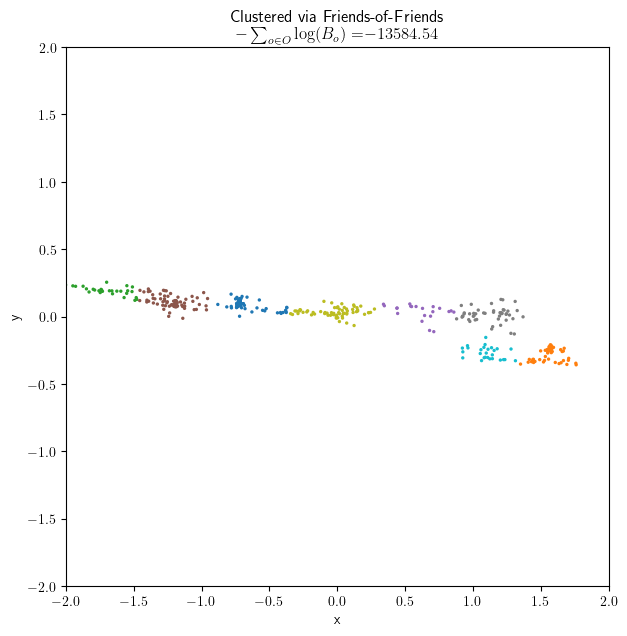

In [7]:
plt.figure(figsize=(7,7))
plt.scatter(data_df['coord1 (arcseconds)'],
            data_df['coord2 (arcseconds)'],
            s=2.0, c = data_df.SubID, cmap='tab10')
plt.title("Clustered via Friends-of-Friends\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes(data_df, list(data_df.SubID)):.2f}$")
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

### KMeans

100%|██████████| 49/49 [00:26<00:00,  1.85it/s]


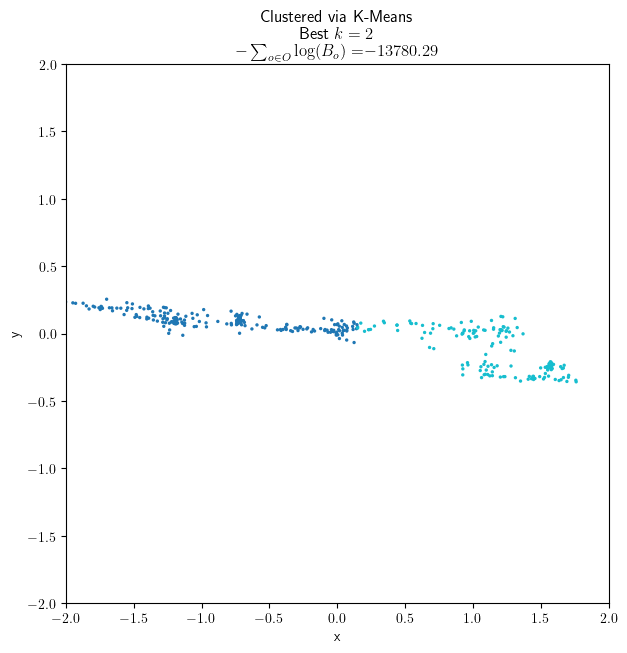

In [10]:
best_labels, best_k, best_bayes = run_kmeans(data_df, 1,50)

plt.figure(figsize=(7,7))
plt.scatter(data_df['coord1 (arcseconds)'],
            data_df['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab10')
plt.title("Clustered via K-Means\n"
          f"Best $k={best_k}$\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${best_bayes:.2f}$")
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

### COP-KMeans

In [6]:
best_labels, best_k, best_bayes = run_cop_kmeans(data_df, 100, 101)

# plt.figure(figsize=(7,7))
# plt.scatter(data_df['coord1 (arcseconds)'],
#             data_df['coord2 (arcseconds)'],
#             s=2.0, c = best_labels, cmap='tab20')
# plt.title("Clustered via K-Means\n"
#           f"Best $k={best_k}$\n"
#               r"$-\sum_{{o\in O}}\log(B_o)=$"
#               f"${best_bayes:.2f}$")
# plt.xlabel('x')
# plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
# plt.show()

100%|██████████| 1/1 [00:10<00:00, 10.18s/it]


## Big Data

In [14]:
big_data_path = "big_data/MyHDF_jacobf18_0.csv"
big_data_df = pd.read_csv(big_data_path)

# Convert Image IDs to integers in range [0, number of images]
big_data_df.ImageID = pd.factorize(big_data_df.ImageID)[0]

# Get kappas (inverse of sigma)
big_data_df["kappa"] = 1 / (big_data_df.Sigma ** 2)
big_data_df["kappa (radians)"] = 1 / ((big_data_df.Sigma*np.pi/180/3600) ** 2)
big_data_df["log kappa (radians)"] = np.log(big_data_df["kappa (radians)"])

# Get center of data points
center_ra = big_data_df.RA.mean()
center_dec = big_data_df.Dec.mean()

center_west, center_north = tangent(center_ra, center_dec)

big_data_df["coord1 (arcseconds)"] = (big_data_df[["X", "Y", "Z"]] @ center_west) * 180 * 3600 / np.pi
big_data_df["coord2 (arcseconds)"] = (big_data_df[["X", "Y", "Z"]] @ center_north) * 180 * 3600 / np.pi

big_data_df

,ImageID,JobID,MatchID,SourceID,X,Y,Z,Sigma,RA,Dec,kappa,kappa (radians),log kappa (radians),coord1 (arcseconds),coord2 (arcseconds)
0,0,35306,4211611957,4000916189528,0.456528,-0.182370,-0.870817,0.02900,338.225364,-60.552930,1189.060564,5.058878e+13,31.554751,10.930064,-5.757109
1,0,35306,4211611904,4000916189529,0.456427,-0.182594,-0.870823,0.01000,338.196765,-60.553629,10000.000000,4.254517e+14,33.684173,61.544402,-8.301104
2,0,35306,4211611842,4000916189530,0.456499,-0.182411,-0.870824,0.01875,338.219733,-60.553715,2844.444444,1.210174e+14,32.426955,20.895535,-8.587093
3,0,35306,4211611919,4000916189532,0.456505,-0.182411,-0.870821,0.01110,338.219887,-60.553379,8116.224123,3.453061e+14,33.475452,20.623653,-7.377742
4,0,35306,4211612082,4000916189535,0.456455,-0.182547,-0.870819,0.02810,338.203047,-60.553056,1266.448045,5.388125e+13,31.617804,50.428467,-6.230797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60500,55,35306,4600995538,4600995538,0.456473,-0.182048,-0.870914,0.10680,338.256965,-60.564915,87.671305,3.729991e+12,28.947427,-46.624523,-46.174268
60501,55,35306,4600995523,4600995523,0.456340,-0.182410,-0.870908,0.02490,338.211995,-60.564248,1612.877199,6.862014e+13,31.859607,32.937911,-43.786583
60502,55,35306,4600995488,4600995488,0.456445,-0.182132,-0.870911,0.07570,338.246640,-60.564574,174.505139,7.424351e+12,29.635786,-28.356915,-44.944932
60503,55,35306,4600995480,4600995480,0.456368,-0.182323,-0.870911,0.14380,338.222590,-60.564618,48.359547,2.057465e+12,28.352496,14.191576,-45.110163


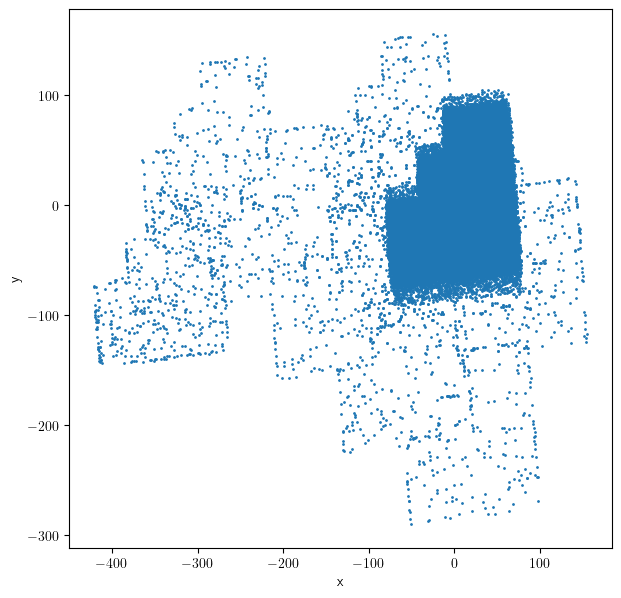

In [15]:
plt.figure(figsize=(7,7))
plt.scatter(big_data_df['coord1 (arcseconds)'],
            big_data_df['coord2 (arcseconds)'],
            s=1.0)
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

100%|██████████| 1/1 [02:55<00:00, 175.12s/it]


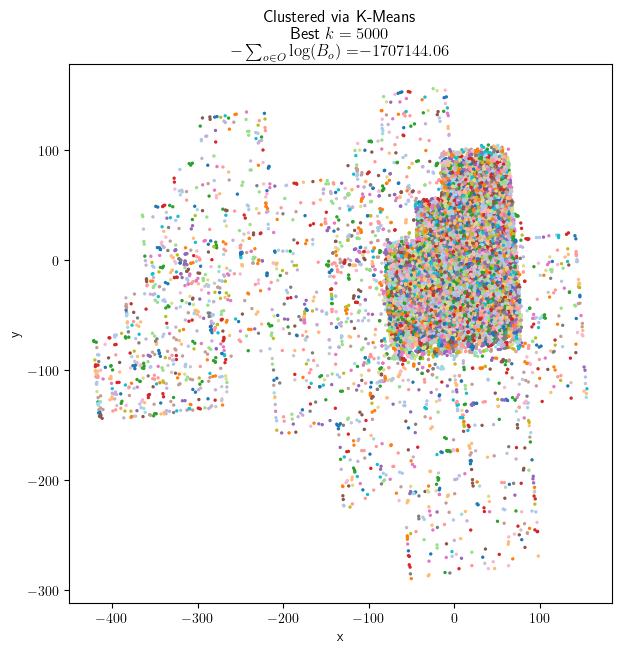

In [16]:
from sklearn.cluster import KMeans
from tqdm import tqdm

best_labels = None
best_k = 0
best_bayes = np.Inf

coords = big_data_df[["coord1 (arcseconds)", "coord2 (arcseconds)"]]
weights = big_data_df["kappa"]

for k in tqdm(range(5000,5001)):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X = coords, sample_weight=weights)

    bayes = neg_log_bayes(big_data_df, kmeans.labels_)

    if bayes < best_bayes:
        best_bayes = bayes
        best_labels = kmeans.labels_
        best_k = k

plt.figure(figsize=(7,7))
plt.scatter(big_data_df['coord1 (arcseconds)'],
            big_data_df['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab20')
plt.title("Clustered via K-Means\n"
          f"$k={best_k}$\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${best_bayes:.2f}$")
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

In [64]:
image_ra_dec = big_data_df.groupby(['ImageID'])[["X", "Y", "Z"]].mean()

image_ra_dec["coord1 (arcseconds)"] = (image_ra_dec[["X", "Y", "Z"]] @ center_west) * 180 * 3600 / np.pi
image_ra_dec["coord2 (arcseconds)"] = (image_ra_dec[["X", "Y", "Z"]] @ center_north) * 180 * 3600 / np.pi

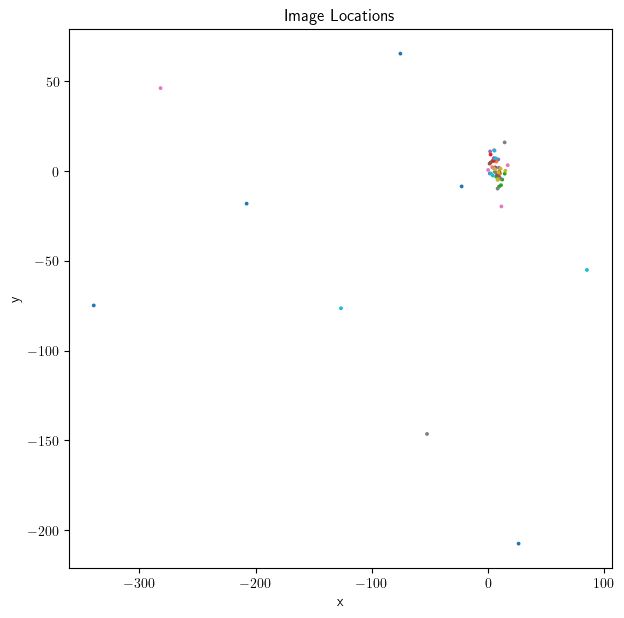

In [68]:
plt.figure(figsize=(7,7))
plt.scatter(image_ra_dec['coord1 (arcseconds)'],
            image_ra_dec['coord2 (arcseconds)'],
            s=3.0, c = image_ra_dec.index, cmap='tab10')
plt.title("Image Locations")
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

In [56]:
import faiss
d = 2 # number of features
ncentroids = 5000

kmeans = faiss.Kmeans(d, ncentroids, niter = 300, verbose = False, gpu = True, nredo = 1)

kmeans.train(coords,weights)

_, labels = kmeans.index.search(coords,1)

neg_log_bayes(big_data_df, list(labels.flatten()))

WARNING clustering 60505 points to 5000 centroids: please provide at least 195000 training points


-1650102.431649264

### COP-Kmeans

In [ ]:
best_labels, best_k, best_bayes = run_cop_kmeans(big_data_df, 100,101)

plt.figure(figsize=(7,7))
plt.scatter(big_data_df['coord1 (arcseconds)'],
            big_data_df['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab20')
plt.title("Clustered via K-Means\n"
          f"Best $k={best_k}$\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${best_bayes:.2f}$")
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

## Match 6000160767697

### Load Data

In [5]:
data_df_2 = pd.read_csv('data/match_6000160767697.csv')

# Convert Image IDs to integers in range [0, number of images]
data_df_2.ImageID = pd.factorize(data_df_2.ImageID)[0]

# Get kappas (inverse of sigma)
# data_df_2["Sigma"] = data_df_2["Sigma"] / np.sqrt(2.3)
data_df_2["kappa"] = 1 / (data_df_2["Sigma"] ** 2)
data_df_2["kappa (radians)"] = 1 / ((data_df_2["Sigma"]*np.pi/180/3600) ** 2)
data_df_2["log kappa (radians)"] = np.log(data_df_2["kappa (radians)"])

# Get center of data points
center_ra = data_df_2.RA.mean()
center_dec = data_df_2.Dec.mean()

center_west, center_north = tangent(center_ra, center_dec)

data_df_2["coord1 (arcseconds)"] = (data_df_2[["X", "Y", "Z"]] @ center_west) * 180 * 3600 / np.pi
data_df_2["coord2 (arcseconds)"] = (data_df_2[["X", "Y", "Z"]] @ center_north) * 180 * 3600 / np.pi


data_df_2

,MatchID,Level,SubID,ImageID,SourceID,X,Y,Z,Sigma,RA,Dec,kappa,kappa (radians),log kappa (radians),coord1 (arcseconds),coord2 (arcseconds)
0,6000160767697,2,0,0,6000160767697,-0.770668,-0.025419,-0.63673,0.02678,181.889145,-39.548367,1394.372724,5.932383e+13,31.714032,0.057720,-0.070164
1,6000160767697,2,0,1,6000200049984,-0.770668,-0.025419,-0.63673,0.02795,181.889145,-39.548367,1280.077715,5.446112e+13,31.628508,0.054930,-0.066913
2,6000160767697,2,0,2,6000509549833,-0.770668,-0.025419,-0.63673,0.02795,181.889097,-39.548468,1280.077715,5.446112e+13,31.628508,0.062785,-0.071690
3,6000160767697,2,0,3,6000443790714,-0.770668,-0.025419,-0.63673,0.02847,181.889097,-39.548466,1233.743970,5.248985e+13,31.591641,0.063094,-0.073348
4,6000160767697,2,0,4,6000510780386,-0.770668,-0.025419,-0.63673,0.03211,181.889148,-39.548365,969.883071,4.126384e+13,31.351008,0.055842,-0.069751
5,6000160767697,2,0,5,6000332395766,-0.770668,-0.025419,-0.63673,0.02925,181.889099,-39.548469,1168.821682,4.972772e+13,31.537584,0.063280,-0.071242
6,6000160767697,2,1,6,6000179832048,-0.770668,-0.025420,-0.63673,0.00828,181.889168,-39.548429,14586.105634,6.205683e+14,34.061657,-0.115376,-0.009996
7,6000160767697,2,1,7,6000435667141,-0.770668,-0.025420,-0.63673,0.00804,181.889172,-39.548426,15469.914258,6.581701e+14,34.120485,-0.116995,-0.009337
8,6000160767697,2,1,8,6000274900085,-0.770668,-0.025420,-0.63673,0.00868,181.889163,-39.548418,13272.737923,5.646909e+14,33.967300,-0.116098,-0.011518
9,6000160767697,2,1,9,6000295587793,-0.770668,-0.025420,-0.63673,0.01472,181.889189,-39.548406,4615.134521,1.963517e+14,32.910928,-0.085463,-0.034497


### Friends of Friends

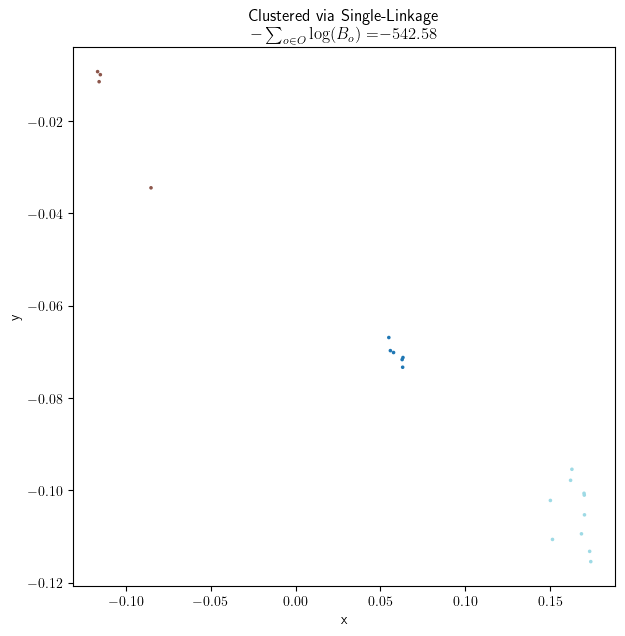

In [6]:
plt.figure(figsize=(7,7))
plt.scatter(data_df_2['coord1 (arcseconds)'],
            data_df_2['coord2 (arcseconds)'],
            s=2.5, c = data_df_2.SubID, cmap='tab20')
plt.title("Clustered via Single-Linkage\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes(data_df_2, list(data_df_2.SubID)):.2f}$")
plt.xlabel('x')
plt.ylabel('y')
plt.show()


### COP-Kmeans

100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 72.95it/s]


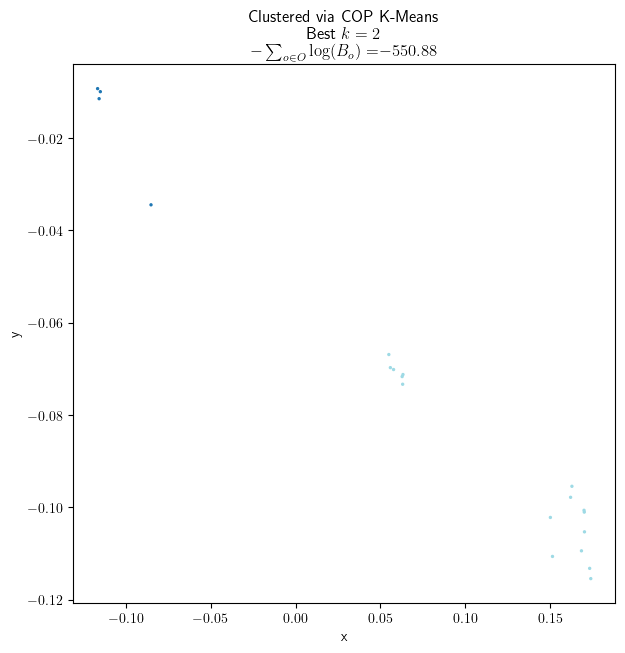

In [60]:
best_labels, best_k, best_bayes = run_cop_kmeans(data_df = data_df_2, min_k = 1, max_k = data_df_2.shape[0])

plt.figure(figsize=(7,7))
plt.scatter(data_df_2['coord1 (arcseconds)'],
            data_df_2['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab20')
plt.title("Clustered via COP K-Means\n"
          f"Best $k={best_k}$\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${best_bayes:.2f}$")
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

### KMeans

100%|███████████████████████████████████████████| 19/19 [00:05<00:00,  3.31it/s]


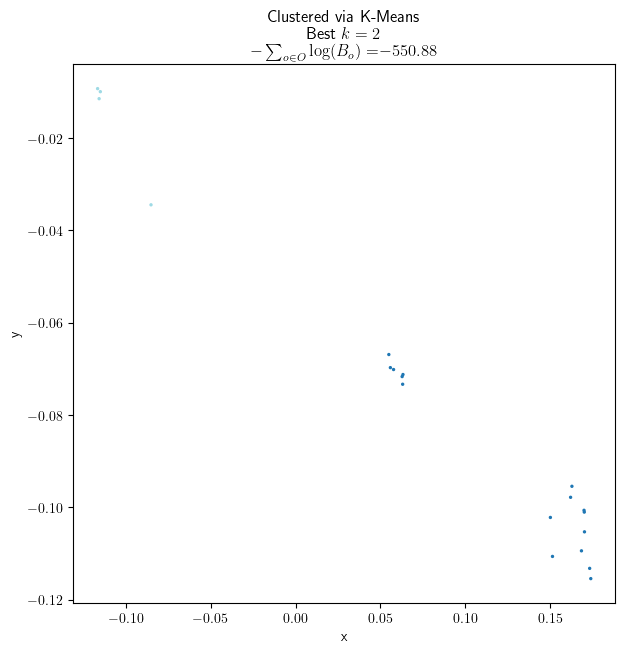

In [59]:
best_labels, best_k, best_bayes = run_kmeans(data_df = data_df_2, min_k = 1, max_k = data_df_2.shape[0])

plt.figure(figsize=(7,7))
plt.scatter(data_df_2['coord1 (arcseconds)'],
            data_df_2['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab20')
plt.title("Clustered via K-Means\n"
          f"Best $k={best_k}$\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${best_bayes:.2f}$")
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

### MIQCP

In [21]:
from gurobipy import Model, GRB, quicksum
from scipy.spatial.distance  import pdist
import itertools
from collections import defaultdict

def miqcp(data_df: pd.DataFrame):
    num_datapoints = data_df.shape[0]
    num_clusters = num_datapoints
    # num_clusters = 10
    num_catalogs = data_df["ImageID"].unique().shape[0]
    dims = 2
    
    C = np.log(constants.ARCSEC_TO_RAD_2) # constant used for arcseconds to radians conversion

    model = Model("MIQCP")

    # Make intermediate lists and dictionaries
    candidate_list = []
    coord_dict = dict()
    kappa_dict = dict()
    kappa_rad_dict = dict()

    for _, row in data_df.iterrows():
        source_image = (row.SourceID, row.ImageID)
        candidate_list.append(source_image)
        coord_dict[source_image] = (row["coord1 (arcseconds)"],row["coord2 (arcseconds)"])
        kappa_dict[source_image] = row["kappa"]
        kappa_rad_dict[source_image] = row["kappa (radians)"]

    # Add cluster variables
    cluster_vars = model.addVars(num_clusters, dims, lb = -float('inf'), ub=float('inf'))

    # Add boolean variables (cluster-sources)
    x = model.addVars(candidate_list, list(range(num_clusters)), vtype=GRB.BINARY)

    for (source, catalog, k), var in x.items():
        var.setAttr("BranchPriority", 1)

    # cluster distances
    p = model.addVars(num_clusters, lb = 0, vtype=GRB.BINARY)

    # Add M variable
    M = np.max(pdist(data_df[["coord1 (arcseconds)", "coord2 (arcseconds)"]])) * data_df["kappa"].max() * 1.1
    # M = 10**6
    
    # Add max cluster distance variables
    r_dict = model.addVars(candidate_list, lb = 0.0, ub = float('inf'))

    # Log term
    rounding_index = -2
    error_threshold = 1/100 * (np.log(data_df["kappa"].min()) + C)

    var_chi_dict = {}
    sigma_max = data_df["Sigma"].max()
    sigma_min = data_df["Sigma"].min()
    
    # b_list = [np.log(1/(sigma_max)**2) + C]
    b_list = [np.log(1/(sigma_max)**2)]
    # Compute b_list
    # while b_list[-1] < np.log(num_catalogs) - np.log((sigma_min)**2) + C:
    while b_list[-1] < np.log(num_catalogs) - np.log((sigma_min)**2):
        b_list.append(b_list[-1]+error_threshold)
        
    num_breakpoints = len(b_list) # = P in the paper

    # Variables for chi
    for j in range(num_clusters):
        for b_i in range(num_breakpoints):
            var_chi_dict[('chi', j, b_i)] = model.addVar(vtype=GRB.BINARY, name=str(('chi', j, b_i)))

    s = model.addVars(num_clusters, lb = 0, vtype=GRB.INTEGER)
    
    ### Objective ###
    sum_ln_kappa_rad = (C * num_datapoints) + np.log(data_df["kappa"]).sum()
    model.setObjective((0.5 * r_dict.sum()) 
                       + (np.log(2) * p.sum()) 
                       - (np.log(2) * s.sum())
                        + quicksum((b_list[0] * var_chi_dict[('chi', j, 0)])
                                    + (error_threshold * quicksum(var_chi_dict[('chi', j, b_i)] 
                                                                  for b_i in range(1,num_breakpoints)))
                                    for j in range(num_clusters))
                       + (p.sum() * C)
                       - sum_ln_kappa_rad
                        , GRB.MINIMIZE)

    ### Constraints
    # Each point assigned to a cluster
    for source, catalog in candidate_list:
        model.addConstr(quicksum(x[(source, catalog, j)] for j in range(num_clusters)) == 1)

    # |# objects| * ln(2)
    # p = 1 if there is a source in that cluster
    # p = 0 if no sources assigned to cluster
    for j in range(num_clusters):
        for source, catalog in candidate_list:
            model.addConstr(p[j] >= x[source,catalog,j])
            
    # |# sources| * ln(2)
    for j in range(num_clusters):
        model.addConstr(s[j] == quicksum(x[source,catalog,j] for source,catalog in candidate_list))

    # Each cluster has at most one source from a catalog
    sources_by_catalog = defaultdict(list)
    for source, catalog in candidate_list:
        sources_by_catalog[catalog].append(source)

    for j,c in itertools.product(range(num_clusters), range(num_catalogs)):
        model.addConstr(quicksum(x[(source,c,j)] for source in sources_by_catalog[c]) <= 1)

    # Min and max for cluster variables
    # Get coordinates
    x_coords = data_df["coord1 (arcseconds)"]
    y_coords = data_df["coord2 (arcseconds)"]

    for j in range(num_clusters):
        model.addConstr(cluster_vars[j,0] == [min(x_coords), max(x_coords)])
        model.addConstr(cluster_vars[j,1] == [min(y_coords), max(y_coords)])

    # Break symmetry
    first_s, first_c = candidate_list[0]
    model.addConstr(x[(first_s, first_c, 0)] == 1)

    # Big-M constraints
    for (source, catalog), coord in coord_dict.items():
        for j in range(num_clusters):
            model.addQConstr((kappa_dict[(source,catalog)] * # in arcseconds^-2
                              (((cluster_vars[j,0] - coord[0]) * (cluster_vars[j,0] - coord[0])) + 
                               ((cluster_vars[j,1] - coord[1]) * (cluster_vars[j,1] - coord[1])))) # in arcseconds ^ 2
                             <= 
                             r_dict[(source, catalog)] + (M * (1 - x[(source, catalog, j)])))
    
    # Definition of variables chi
    # Equation B19
    for j in range(num_clusters):
        chi_constraint_with_b = []
        chi_constraint = []
        x_constraint = []
        for breakpoint_index in range(1, num_breakpoints):
            #Divide by 10**10 to scale the coefficient so that the matrix range is not so large across all the constraints
            # chi_constraint_with_b.append(var_chi_dict[('chi', j, breakpoint_index)]*(np.exp(b_list[breakpoint_index])-np.exp(b_list[breakpoint_index-1]))/10**10)
            chi_constraint_with_b.append(var_chi_dict[('chi', j, breakpoint_index)]*(np.exp(b_list[breakpoint_index])-np.exp(b_list[breakpoint_index-1])))
        for source, catalog in candidate_list:
            # x_constraint.append(x[(source, catalog, j)]*kappa_rad_dict[(source, catalog)]/10**10) 
            x_constraint.append(x[(source, catalog, j)]*kappa_dict[(source, catalog)]) 
            #Divide by 10**10 to scale the coefficient so that the matrix range is not so large across all the constraints
        model.addConstr(np.exp(b_list[0])* var_chi_dict[('chi', j, 0)] + quicksum(variable for variable in chi_constraint_with_b) >= quicksum(variable for variable in x_constraint))
        
        for breakpoint_index in range(num_breakpoints):
            chi_constraint.append(var_chi_dict[('chi', j, breakpoint_index)])
        for chi_index in range(len(chi_constraint) - 1):
            model.addConstr(chi_constraint[chi_index] >= chi_constraint[chi_index + 1])
    
    ### Solve MIQCP
    # model.setParam('NodefileStart', 5.0)
    # model.setParam("PreDual", 1)
    # model.setParam("PreQLinearize", 2)
    # model.setParam("NumericFocus", 2) # for numerical stability

    model.optimize()

    labels = []
    for (source, catalog, j), var in x.items():
        if var.X > 0.5:
            labels.append(j)
    assert len(labels) == num_datapoints # sanity check that every point is assigned a label
    
    return pd.factorize(labels)[0] # factorize sets labels from 0 to max_labels

labels = miqcp(data_df_2)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1321 rows, 980 columns and 3781 nonzeros
Model fingerprint: 0x08995e30
Model has 400 quadratic constraints
Variable types: 100 continuous, 880 integer (860 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+04]
  QMatrix range    [5e+02, 2e+04]
  QLMatrix range   [1e+00, 5e+03]
  Objective range  [3e-01, 3e+01]
  Bounds range     [1e-01, 1e+00]
  RHS range        [9e-03, 1e+00]
  QRHS range       [5e+03, 5e+03]
Presolve removed 145 rows and 86 columns
Presolve time: 0.02s
Presolved: 1176 rows, 894 columns, 4591 nonzeros
Presolved model has 20 quadratic constraint(s)
Variable types: 80 continuous, 814 integer (814 binary)

Root relaxation: objective -6.106690e+02, 2006 iterations, 0.03 seconds (0.05 work units)

Interrupt request rece

[0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]


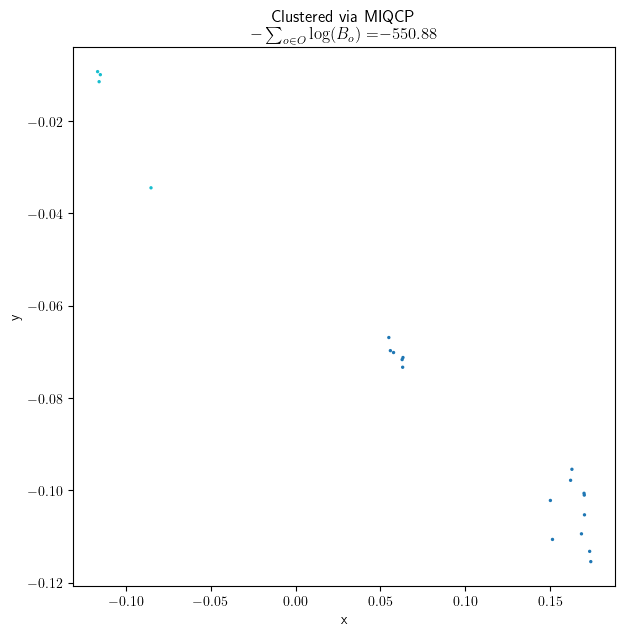

In [22]:
print(labels)
plt.figure(figsize=(7,7))
plt.scatter(data_df_2['coord1 (arcseconds)'],
            data_df_2['coord2 (arcseconds)'],
            s=2.0, c = labels, cmap='tab10')
plt.title("Clustered via MIQCP\n"
            r"$-\sum_{{o\in O}}\log(B_o)=$"
            f"${neg_log_bayes(data_df_2, labels):.2f}$")
plt.xlabel('x')
plt.ylabel('y')
plt.show()